In [1]:
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import StackingRegressor, StackingClassifier
import optuna
import xgboost as xgb
import lightgbm as lgb


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ПОКА EDA

In [2]:
df_raw = pl.read_csv("train.csv")
df_test_raw = pl.read_csv("test.csv")

In [3]:
df_raw.head()

id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
i64,str,f64,f64,f64,f64,f64,f64,f64,i64
0,"""I""",1.525,1.175,0.375,28.973189,12.728926,6.647958,8.348928,9
1,"""I""",1.1,0.825,0.275,10.418441,4.521745,2.324659,3.40194,8
2,"""M""",1.3875,1.1125,0.375,24.777463,11.3398,5.556502,6.6621325,9
3,"""F""",1.7,1.4125,0.5,50.660556,20.354941,10.991839,14.996885,11
4,"""I""",1.25,1.0125,0.3375,23.289114,11.977664,4.5075705,5.953395,8


In [4]:
df_raw.describe()

statistic,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",74051.0,"""74051""",74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",37025.0,null,1.31746,1.024496,0.348089,23.385217,10.10427,5.058386,6.72387,9.967806
"""std""",21376.826729,null,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
"""min""",0.0,"""F""",0.1875,0.1375,0.0,0.056699,0.0283495,0.042524,0.042524,1.0
"""25%""",18513.0,null,1.15,0.8875,0.3,13.437663,5.712424,2.8632995,3.96893,8.0
"""50%""",37025.0,null,1.375,1.075,0.3625,23.799405,9.90815,4.989512,6.931453,10.0
"""75%""",55538.0,null,1.5375,1.2,0.4125,32.162508,14.033003,6.988152,9.07184,11.0
"""max""",74050.0,"""M""",2.0128145,1.6125,2.825,80.101512,42.184056,21.54562,28.491248,29.0


In [5]:
df_raw.shape

(74051, 10)

In [6]:
def fix_bad_height(df):
    median_height = (df.filter(pl.col("Height") > 0).select(pl.col("Height").median()).item())
    return df.with_columns(pl.when(pl.col("Height") == 0).then(median_height).otherwise(pl.col("Height")).alias("Height"))

In [7]:
def plot_box_by_sex(df):
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df,x="Sex",y="Age",width=0.6)

    plt.title("Box для пола")
    plt.xlabel("Sex")
    plt.ylabel("Age")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def one_hot_sex(df):
    return (df.with_columns([(pl.col("Sex") == "M").cast(pl.Int8).alias("M"),
                             (pl.col("Sex") == "F").cast(pl.Int8).alias("F"),
                             (pl.col("Sex") == "I").cast(pl.Int8).alias("I"),]).drop("Sex"))

In [9]:
df = fix_bad_height(df_raw)

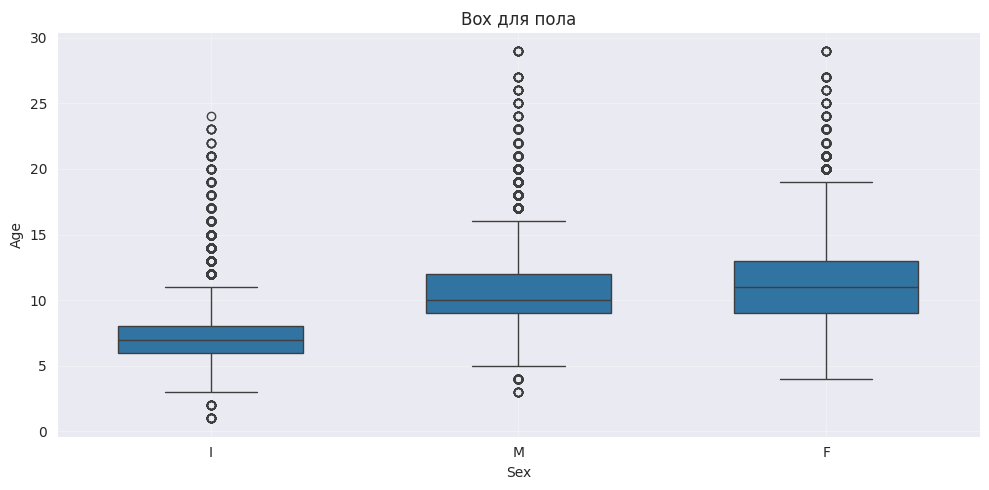

In [10]:
plot_box_by_sex(df)

In [11]:
df = one_hot_sex(df)

In [12]:
df.shape

(74051, 12)

In [13]:
df.describe()

statistic,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,M,F,I
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",37025.0,1.31746,1.024496,0.348207,23.385217,10.10427,5.058386,6.72387,9.967806,0.365748,0.310732,0.32352
"""std""",21376.826729,0.287757,0.237396,0.091821,12.648153,5.618025,2.792729,3.584372,3.175189,0.481643,0.462796,0.467822
"""min""",0.0,0.1875,0.1375,0.0125,0.056699,0.0283495,0.042524,0.042524,1.0,0.0,0.0,0.0
"""25%""",18513.0,1.15,0.8875,0.3,13.437663,5.712424,2.8632995,3.96893,8.0,0.0,0.0,0.0
"""50%""",37025.0,1.375,1.075,0.3625,23.799405,9.90815,4.989512,6.931453,10.0,0.0,0.0,0.0
"""75%""",55538.0,1.5375,1.2,0.4125,32.162508,14.033003,6.988152,9.07184,11.0,1.0,1.0,1.0
"""max""",74050.0,2.0128145,1.6125,2.825,80.101512,42.184056,21.54562,28.491248,29.0,1.0,1.0,1.0


In [14]:
ages = df.select([
    pl.col("Age").mean().alias("age mean"),
    pl.col("Age").median().alias("age median"),
    pl.col("Age").std().alias("age std"),
    pl.col("Age").min().alias("age min"),
    pl.col("Age").max().alias("age max")
])

In [15]:
ages

age mean,age median,age std,age min,age max
f64,f64,f64,i64,i64
9.967806,10.0,3.175189,1,29


In [16]:
def plot_KDE_Box(df):
    sns.set_style("darkgrid")
    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.kdeplot(data=df, x="Age", ax=axes[0], fill=True)
    axes[0].set_title("KDE")
    axes[0].grid(True, alpha=0.3)
    sns.boxplot(data=df, x="Age", ax=axes[1], width=0.6)
    axes[1].set_title("Box")
    plt.tight_layout()

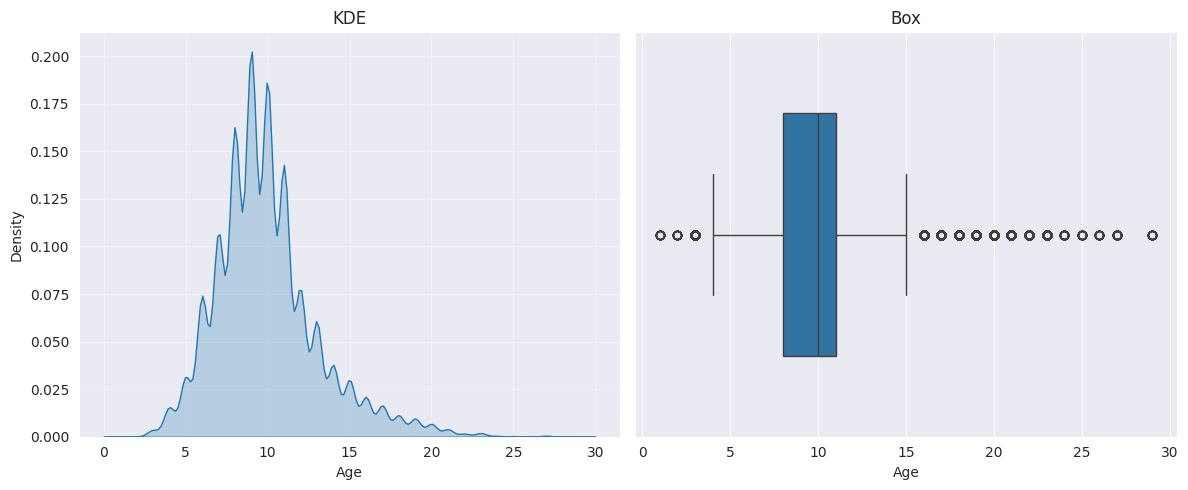

In [17]:
plot_KDE_Box(df)

In [18]:
def create_basic_features(df):
    col = pl.col
    return df.with_columns(
        Meat_Yield=col("Shucked Weight") / (col("Weight") + col("Shell Weight")),
        Surface_Area=2 * (
            col("Length") * col("Diameter") + col("Length") * col("Height") + col("Diameter") * col("Height")),
        Weight_to_ShuckedWeight_Ratio=col("Weight") / col("Shucked Weight"),
        Pseudo_BMI=col("Weight") / (col("Height")).pow(2),
        Weight_to_Length_Squared=col("Weight") / col("Length").pow(2),
        Viscera_Ratio=col("Viscera Weight") / col("Weight"),
        #####
        # Shell_Ratio = col("Shell Weight") / (col("Weight")),
        # Shell_to_Body_Ratio = col("Shell Weight") / (col("Weight") + col("Shell Weight")),
        # Length_to_Diameter = col("Length") / (col("Diameter")),
        # Weight_to_VisceraWeight = col("Weight") / (col("Viscera Weight")),
        # Weight_to_ShellWeight = col("Weight") / (col("Shell Weight")),

        # Volume = col("Length") * col("Diameter") * col("Height"),
        # Density = col("Weight") / (col("Length") * col("Diameter") * col("Height")),

        # Length_sq = col("Length").pow(2),
        # Diameter_sq = col("Diameter").pow(2),

        # Log_Weight = (col("Weight") + 1).log(),
        
        # Weight_wo_Viscera = col("Shucked Weight") - col("Viscera Weight"),
        # Body_Condition_Index = ((col("Length") * col("Weight") * col("Shucked Weight")).sqrt()),
    )

In [19]:
df_added_features = create_basic_features(df)

In [20]:
df_added_features.describe()

statistic,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,M,F,I,Meat_Yield,Surface_Area,Weight_to_ShuckedWeight_Ratio,Pseudo_BMI,Weight_to_Length_Squared,Viscera_Ratio
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0,74051.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",37025.0,1.31746,1.024496,0.348207,23.385217,10.10427,5.058386,6.72387,9.967806,0.365748,0.310732,0.32352,0.334395,4.554214,2.357613,174.790464,11.845261,0.216989
"""std""",21376.826729,0.287757,0.237396,0.091821,12.648153,5.618025,2.792729,3.584372,3.175189,0.481643,0.462796,0.467822,0.062859,1.82033,0.30954,195.345353,3.050072,0.030319
"""min""",0.0,0.1875,0.1375,0.0125,0.056699,0.0283495,0.042524,0.042524,1.0,0.0,0.0,0.0,0.06383,0.067813,0.211635,2.110061,1.079981,0.042254
"""25%""",18513.0,1.15,0.8875,0.3,13.437663,5.712424,2.8632995,3.96893,8.0,0.0,0.0,0.0,0.305613,3.26375,2.157168,145.7536,9.911629,0.199111
"""50%""",37025.0,1.375,1.075,0.3625,23.799405,9.90815,4.989512,6.931453,10.0,0.0,0.0,0.0,0.334661,4.79375,2.313682,174.324477,12.234384,0.215816
"""75%""",55538.0,1.5375,1.2,0.4125,32.162508,14.033003,6.988152,9.07184,11.0,1.0,1.0,1.0,0.362179,5.9303125,2.509002,200.034072,13.951764,0.233642
"""max""",74050.0,2.0128145,1.6125,2.825,80.101512,42.184056,21.54562,28.491248,29.0,1.0,1.0,1.0,3.944223,14.710625,12.0,23314.6288,87.404964,1.32363


In [21]:
y = df_added_features["Age"]
X = df_added_features.drop("Age")

In [22]:
basic_features = [
  "Length",
  "Diameter",
  "Height",
  "Weight", 
  "Shucked Weight",
  "Viscera Weight",
  "Shell Weight",
  ########
  "Meat_Yield",
  "Surface_Area",
  "Weight_to_ShuckedWeight_Ratio",
  "Pseudo_BMI",
  "Weight_to_Length_Squared",
  "Viscera_Ratio",
  #########
  "M",
  "F",
  "I"#,
  #########
  # "Shell_Ratio",
  # "Shell_to_Body_Ratio",
  # "Length_to_Diameter",
  # "Weight_to_VisceraWeight",
  # "Weight_to_ShellWeight",
  # "Volume",
  # "Density",
  # "Length_sq",
  # "Diameter_sq",
  # "Log_Weight",
  # "Weight_wo_Viscera",
  # "Body_Condition_Index"
]

X = X.select(basic_features).to_numpy()
y = y.to_numpy()

# ТУТ УЖЕ БЕЙСЛАЙН 1

In [23]:
def baseline_first_train(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae, pipeline

In [24]:
model = GradientBoostingRegressor(n_estimators=500, loss="absolute_error")
mae, ModelGradBoostSimple = baseline_first_train(model, X, y)
print(mae)

1.3763888007392744


# ДОБАВЛЯЕМ СТЕКИНГ

In [25]:
def stacking_cool_model(base_models, meta_model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline = Pipeline([("scaler", StandardScaler()), ("stacking",
         StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            n_jobs=-1,
            passthrough=True
        ))
    ])
    pipeline.fit(X_train, y_train)
    y_pred_raw = pipeline.predict(X_val)
    best_mae = float("inf")
    best_th = 0.0
    thresholds = np.linspace(-0.49, 0.49, 100)
    for th in thresholds:
        y_val_pred_round = np.floor(y_pred_raw + 0.5 + th).astype(int)
        mae = mean_absolute_error(y_val, y_val_pred_round)
        if mae < best_mae:
            best_mae = mae
            best_th = th
    y_pred_final = np.floor(y_pred_raw + 0.5 + best_th).astype(int)
    mae = mean_absolute_error(y_val, y_pred_final)
    print(mae)
    return pipeline, best_th

In [28]:
def tune_model(model_name, X, y, n_trials):
    
    def objective(trial):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        if model_name == "xgb":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 800),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "n_jobs": -1,
                "random_state": 42,
                "objective": "reg:absoluteerror",
                "eval_metric": "mae"
            }
            model = xgb.XGBRegressor(**params)
        elif model_name == "rf":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 5, 25),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "n_jobs": -1,
                "random_state": 42,
            }
            model = RandomForestRegressor(**params)
        elif model_name == "gbr":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 300),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
                "max_depth": trial.suggest_int("max_depth", 3, 8),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "random_state": 42,
                "loss": "absolute_error"
            }
            model = GradientBoostingRegressor(**params)
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_val_scaled)
        mae = mean_absolute_error(y_val, preds)
        return mae
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [29]:
xgb_best_params = tune_model("xgb", X, y, n_trials=20)
rf_best_params = tune_model("rf", X, y, n_trials=10)
gbr_best_params = tune_model("gbr", X, y, n_trials=10)

[I 2025-12-16 12:39:19,323] A new study created in memory with name: no-name-3c6acf26-81d8-4cbb-ac68-f05b95de0c4a
[I 2025-12-16 12:39:25,572] Trial 0 finished with value: 1.3683580160140991 and parameters: {'n_estimators': 483, 'learning_rate': 0.03736373897201569, 'max_depth': 10, 'subsample': 0.6332465782422001, 'colsample_bytree': 0.5077972624023928, 'min_child_weight': 3}. Best is trial 0 with value: 1.3683580160140991.
[I 2025-12-16 12:39:30,539] Trial 1 finished with value: 1.3604594469070435 and parameters: {'n_estimators': 385, 'learning_rate': 0.015460005904665269, 'max_depth': 10, 'subsample': 0.6239576655095744, 'colsample_bytree': 0.5740331122489466, 'min_child_weight': 10}. Best is trial 1 with value: 1.3604594469070435.
[I 2025-12-16 12:39:37,294] Trial 2 finished with value: 1.359167218208313 and parameters: {'n_estimators': 532, 'learning_rate': 0.01331297194214797, 'max_depth': 9, 'subsample': 0.8940623816816549, 'colsample_bytree': 0.6583679540361045, 'min_child_weigh

In [30]:
xgb_final = xgb.XGBRegressor(
    **xgb_best_params,
    n_jobs=-1,
    random_state=42,
    objective="reg:absoluteerror",
    eval_metric="mae"
)

rf_final = RandomForestRegressor(
    **rf_best_params,
    n_jobs=-1,
    random_state=42,
    criterion="absolute_error"
)

gbr_final = GradientBoostingRegressor(
    **gbr_best_params,
    random_state=42,
    loss="absolute_error"
)

base_models = [("rf", rf_final), ("gbr", gbr_final), ("xgb", xgb_final)]
meta_model = Ridge(alpha=1.0)

In [31]:
op_model, op_th = stacking_cool_model(base_models, meta_model, X, y)

1.3435284585780838


# ЧАСТЬ С ЗАЛИВКОЙ НА КАГГЛ

In [32]:
df_test_raw.shape

(49368, 9)

In [33]:
df_test_raw.describe()

statistic,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
str,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",49368.0,"""49368""",49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",98734.5,null,1.319795,1.026357,0.348693,23.464627,10.13022,5.072615,6.745876
"""std""",14251.458382,null,0.28695,0.236593,0.092259,12.641703,5.611779,2.791563,3.57565
"""min""",74051.0,"""F""",0.1875,0.1375,0.0,0.056699,0.0283495,0.014175,0.042524
"""25%""",86393.0,null,1.1625,0.8875,0.3,13.536886,5.740774,2.877474,3.96893
"""50%""",98735.0,null,1.3875,1.075,0.3625,23.81358,9.979024,4.989512,6.9456275
"""75%""",111076.0,null,1.5375,1.2,0.4125,32.290081,14.047177,7.016501,9.171063
"""max""",123418.0,"""M""",2.0375,1.625,2.825,80.101512,42.184056,21.54562,28.491248


In [34]:
df_test = fix_bad_height(df_test_raw)
df_test = one_hot_sex(df_test)

In [35]:
df_test.shape

(49368, 11)

In [36]:
df_test.describe()

statistic,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,M,F,I
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",98734.5,1.319795,1.026357,0.348795,23.464627,10.13022,5.072615,6.745876,0.363049,0.313604,0.323347
"""std""",14251.458382,0.28695,0.236593,0.092073,12.641703,5.611779,2.791563,3.57565,0.480884,0.463962,0.467759
"""min""",74051.0,0.1875,0.1375,0.025,0.056699,0.0283495,0.014175,0.042524,0.0,0.0,0.0
"""25%""",86393.0,1.1625,0.8875,0.3,13.536886,5.740774,2.877474,3.96893,0.0,0.0,0.0
"""50%""",98735.0,1.3875,1.075,0.3625,23.81358,9.979024,4.989512,6.9456275,0.0,0.0,0.0
"""75%""",111076.0,1.5375,1.2,0.4125,32.290081,14.047177,7.016501,9.171063,1.0,1.0,1.0
"""max""",123418.0,2.0375,1.625,2.825,80.101512,42.184056,21.54562,28.491248,1.0,1.0,1.0


In [37]:
df_sub_with_features = create_basic_features(df_test)
submission_ids = df_test["id"]

In [38]:
df_test.describe()

statistic,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,M,F,I
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0,49368.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",98734.5,1.319795,1.026357,0.348795,23.464627,10.13022,5.072615,6.745876,0.363049,0.313604,0.323347
"""std""",14251.458382,0.28695,0.236593,0.092073,12.641703,5.611779,2.791563,3.57565,0.480884,0.463962,0.467759
"""min""",74051.0,0.1875,0.1375,0.025,0.056699,0.0283495,0.014175,0.042524,0.0,0.0,0.0
"""25%""",86393.0,1.1625,0.8875,0.3,13.536886,5.740774,2.877474,3.96893,0.0,0.0,0.0
"""50%""",98735.0,1.3875,1.075,0.3625,23.81358,9.979024,4.989512,6.9456275,0.0,0.0,0.0
"""75%""",111076.0,1.5375,1.2,0.4125,32.290081,14.047177,7.016501,9.171063,1.0,1.0,1.0
"""max""",123418.0,2.0375,1.625,2.825,80.101512,42.184056,21.54562,28.491248,1.0,1.0,1.0


In [39]:
def get_predict(pipeline, X, threshold):
    y_pred = pipeline.predict(X)
    y_pred = np.floor(y_pred + 0.5 + threshold).astype(int)
    return y_pred

In [40]:
X_sub = df_sub_with_features.select(basic_features).to_numpy()

In [41]:
def get_CSV(model, X, flag):
    y_pred_sub = get_predict(model, X, op_th)
    submission = (df_test.select("id").with_columns(pl.Series("yield", y_pred_sub.tolist())))
    if flag:
        submission.write_csv("submission_op.csv")
    else:
        submission.write_csv("submission_baseline.csv")

In [42]:
get_CSV(op_model, X_sub, flag=True)

In [43]:
get_CSV(ModelGradBoostSimple, X_sub, flag=False)